# Predict Airbnb NYC Listing Price

## Jiawen Meng


## Problem
Airbnb is a popular online marketplace for people to list short-term lodging and visitors to rent apts/rooms for accommodations. Nowadays more people prefer airbnb over traditional hotels for its cultural immersion experience and customized travel services based on host’s local knowledge. 

However, it is difficult for traveler to identify a fair rental price for the uniqueness and not-standardized rental listing, especially travelling to a new location. For house owner, it's also a tough question to pick a competitive price that bringing the most visitors while gaining the most revenue. 

Determining a well-positioned price can also help Airbnb expand business market, optimizing revenue performance, and foster stronger user base. Airbnb charges service fees over both host and guest every time a booking is completed. The amount of the host service fee is generally 3%, but may range between 3-5% depending on the cancellation policy selected by the Host. The host service fee is calculated from the booking subtotal (before fees and taxes) and is automatically deducted from the payout to the Host. When a reservation is confirmed, we charge guests a service fee between 5% and 15% of the reservation subtotal. [link](https://www.airbnb.com/help/article/1857/what-are-airbnb-service-fees) Given Airbnb's business model, growing and consistent reservation through Airbnb is key to ensure Airbnb's success. Pricing strategy plays a very important role to ensure this goal.

The idea is to use airbnb's historical listing data to develop a set of key classifiers and a regression model to predict an appropriate price for a listing. This can be used as an Airbnb internal tool to providing recommendations to Airbnb property owners about appropriate pricing for their listings, or as a external feature to help visitor better understand price range based on types of housing they’re searching. Some of the key features impacting listing price are: Listing location, key amenities, review history.

## Datasets
"Inside Airbnb" project has published complete listing data available within a single city including owner’s profile, listing amenities and price. The listing dataset for New York City [(link)](http://data.insideairbnb.com/united-states/ny/new-york-city/2017-09-02/data/listings.csv.gz) includes 41,157 listings posted in New York City as of September 2, 2017. 

The dataset contains 96 fields describing each listing, e.g. host bio, description of the space offered, neighborhood, local transit, amenities offered, number of bed and bathrooms, type of property, type of bed, square-footage of the space, cumulative review score. The per-night price, weekly price, and monthly price are all available. Here we only use the per-night price as the predicted result. 

## Outcome
The goal is to build a regression model that can accurately predict listing price. I will conduct data exploration analysis, use random forest regressor and other techniques to help with feature selection, split the data into training/test set to fit the regression model, and conduct K-fold cross validation to improve model performance.

Some metrics I will use to evaluate model fit: 

- Mean Absolute Error
- Mean Squared Error
- R^2 - find the highest R^2 that is cloest to 1

_**Alternative hypotheses**_: Airbnb also published a seperate dataset "review.csv" which contains all reviews created within past year for listings within a single city. We can join this dataset with the lisitng dataset to identify which listing obtain at least one review within last year, then turn the final project question into a classification one:"Use key features to determine whether a listing will obtain a review or not". The metrics to evaluate model fit will then be: logloss, AUC, Accuracy, Confusion Metric.

## Reference Project
 * https://www.kaggle.com/ibjohnsson/predicting-listing-prices 
 * https://cseweb.ucsd.edu/classes/wi17/cse258-a/reports/a052.pdf 
 * http://cs229.stanford.edu/proj2015/236_report.pdf 

## Project Concerns

* Location is a key feature to determine price and neighbourhood is a good factor to describe the location. Some neighbourhood has 2000+ listings while other might only have 20. The smaller neighbourhood might not get accurate predicted result. I will first use borough as the location category, then try to add the neighbourhood layer in. If needed, I will consider to categorize smaller neighbourhood into one category to make the group more represented. 

* Due to seasonality, listing price might go up or down. How to capture this factor in the model?

* "Listing info" field contains the listing overview wrote by the host. It's a text data field. This is normally the first thing a user will read so it might be valuable to conduct some sentiment analysis or generate some summarized columns (number of characters) that can be used in the model.  

* Listing reviews are crucial for user to pick the favorate place to stay. Especially in this social media era, people really buy in the word of mouth effect. How should we factor in the review factor into the model? Should it be binary (yes or no), or numerical (number of reviews)? What if a house owner want to post a listing for the very first time and does not have any review history, how would the property owner take in this information?

* Transit is a key factor to determine price. However, this information is stored in the "transit" column in text format. Since this is an optional field, about 50% of the listings do not have this information. Should we extract the transit information from text data into category, or instead use logitute and latitute to compare with key subway stop and generate new column to represent transit factor?

* Other neighborhood aspects can impact listing price greatly but not captured in the given dataset. For example, gentrifying neighbourhood will have a higher listing price trend. In future work, it would be interesting to understand the correlations between neighborhoods and prices more deeply. Tracing out the qualities of neighborhoods that encourage consumers to pay higher prices may be an important application for real estate / urban planning. Neighborhood impression.

## Import Package and Datasets
** Import pandas, numpy, matplotlib,and seaborn. Then set %matplotlib inline 

In [1]:
#imports
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pylab as pl
import numpy as np
import seaborn as sns
from scipy import stats, integrate
from collections import Counter

pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns', 999)

pd.set_option('display.float_format', lambda x: '%.3f' % x)

%matplotlib inline

C:\Users\jmeng\AppData\Local\Continuum\anaconda2\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [4]:
#nyc_listing= pd.read_csv("/Users/jamie/Desktop/GA/Final Projects/NYC-airbnb-open-data/listings.csv",low_memory=False)

nyc_listing= pd.read_csv("C:\Users\jmeng\Desktop\DAT-NYC-8.29.17-master\listings.csv",low_memory=False)

## Review and Clean Datasets
Dataset has 96 variables with 41,157 rows. Many columns have nan values or missing values. Need to further clean the dataset.

### Some Variable Definitions

-  id: listing unique identifier.
-  accommodates:  property capacity in NYC.
-  bathrooms:  number of bathrooms in the properties within the NYC.
-  bedrooms:  number of bedrooms in the properties within the NYC.
-  beds:  number of beds in the properties within the NYC.
-  number_of_reviews:  number of reviews received by the properties within the NYC.
-  reviews_per_month:  number of reviews per month received by the properties within the NYC.
-  review_scores_ratings:  rating score received by the properties within the NYC.
-  review_scores_accuracy:  accuracy score received by the properties within the NYC.
-  review_scores_cleanliness:  cleanliness score received by the properties within the NYC.
-  review_scores_checkin:  checkin score received by the properties within the NYC.
-  review_scores_communication:  communication score received by the properties within the NYC.
-  review_scores_location:  location score received by the properties within the NYC.
-  review_scores_value:  value score received by the properties within the NYC.

In [5]:
nyc_listing.shape

(41157, 96)

In [ ]:
nyc_listing.head(n=3)

In [ ]:
#Examine fields with null values
nyc_listing.isnull().sum()[nyc_listing.isnull().sum() != 0].sort_values(ascending=False)

In [9]:
# Remove columns with only NULL
nyc_listing.dropna(axis=1,how='all',inplace = True)

In [10]:
# Remove columns unrelated to the research question
columns = ['id','scrape_id','last_scraped','picture_url',
'host_id','host_url','host_name','host_thumbnail_url','host_picture_url','host_listings_count','host_total_listings_count',
'calendar_updated',
'availability_30','availability_60','availability_90','availability_365','calendar_last_scraped',
'requires_license',
'instant_bookable',
'require_guest_profile_picture',
'require_guest_phone_verification',
'calculated_host_listings_count',
'require_guest_phone_verification',
'calculated_host_listings_count','experiences_offered','host_since','host_location','state',
'zipcode','market','smart_location','country_code','country','city','neighbourhood','host_is_superhost','host_neighbourhood',
'first_review','last_review','extra_people','guests_included',
'square_feet','weekly_price','monthly_price','security_deposit',
'jurisdiction_names','notes','interaction','cleaning_fee','is_location_exact','street',
'host_response_time','host_response_rate','host_verifications'
,'amenities','property_type']

nyc_listing.drop(columns,axis=1, inplace=True)

In [11]:
# Drop rows with missing values or 0 in key columns, like 0 bedroom, bathroom, or bed. 
print len(nyc_listing[nyc_listing['bedrooms'] == 0])
print nyc_listing['bedrooms'].isnull().sum()
print nyc_listing['beds'].isnull().sum()
print nyc_listing['bathrooms'].isnull().sum()

nyc_listing = nyc_listing[np.isfinite(nyc_listing['bedrooms'])]
nyc_listing = nyc_listing[np.isfinite(nyc_listing['beds'])]
nyc_listing = nyc_listing[nyc_listing['bedrooms'] != 0]
nyc_listing['bathrooms'].fillna(0,inplace=True)
#nyc_listing.dropna(subset=['host_response_time'], inplace = True) 

3656
64
66
138


In [12]:
# Drop rows with null in review related columns, to narrow down the model for listings with existing review scores.
nyc_listing = nyc_listing[np.isfinite(nyc_listing['review_scores_value'])]
nyc_listing = nyc_listing[np.isfinite(nyc_listing['review_scores_location'])]
nyc_listing = nyc_listing[np.isfinite(nyc_listing['review_scores_checkin'])]
nyc_listing = nyc_listing[np.isfinite(nyc_listing['review_scores_cleanliness'])]                       
nyc_listing = nyc_listing[np.isfinite(nyc_listing['review_scores_communication'])]
nyc_listing = nyc_listing[np.isfinite(nyc_listing['review_scores_accuracy'])]                       
nyc_listing = nyc_listing[np.isfinite(nyc_listing['review_scores_rating'])]   

In [13]:
# fill out 0 for missing values in review_per_month and number_of_reviews
nyc_listing['reviews_per_month'].fillna(0,inplace=True)
nyc_listing['number_of_reviews'].fillna(0,inplace=True)

In [15]:
# Drop columns with at least 30% are null
nyc_listing = nyc_listing.loc[:, (nyc_listing.isnull().sum(axis=0) <= max_number_of_nas)]

In [ ]:
# Review Dataset
nyc_listing.info()

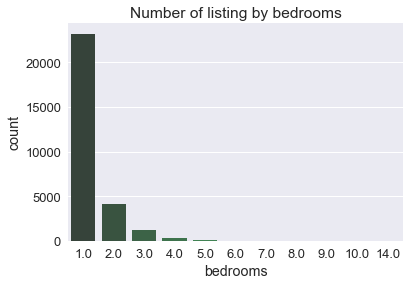

In [17]:
# Majority of the listing's bedroom is 1. Scope down dataset to only listings with 1 bedroom.
sns.set(style="whitegrid", color_codes=True)
sns.set(font_scale=1.3)

sns.countplot(x="bedrooms", data= nyc_listing, palette="Greens_d").set_title('Number of listing by bedrooms');

nyc_listing = nyc_listing[nyc_listing.bedrooms == 1]

In [18]:
#Examine fields still with null values. Consider to delete lines with null values, or replace null with more meaningful values.
nyc_listing.isnull().sum()[nyc_listing.isnull().sum() != 0].sort_values(ascending=False)

summary                   1003
host_identity_verified      41
host_has_profile_pic        41
description                  8
name                         5
dtype: int64

In [19]:
# Almost all listing has host profile picture. Consider to drop this column
nyc_listing.host_has_profile_pic.value_counts()

t    23140
f       40
Name: host_has_profile_pic, dtype: int64

In [20]:
nyc_listing.drop('host_has_profile_pic',axis=1, inplace=True)

In [21]:
# For "host_identity_verified", replace t and f with 1 and 0, then drop the lines 
nyc_listing['host_identity_verified'].replace('t',1,inplace=True)
nyc_listing['host_identity_verified'].replace('f',0,inplace=True)

nyc_listing.host_identity_verified.value_counts()

1.000    16764
0.000     6416
Name: host_identity_verified, dtype: int64

In [22]:
nyc_listing = nyc_listing[nyc_listing['host_identity_verified'].isnull() == False]

In [23]:
# We will also drop the lines with null in "name" column
nyc_listing = nyc_listing[nyc_listing['name'].isnull() == False]
nyc_listing = nyc_listing[nyc_listing['description'].isnull() == False]
nyc_listing = nyc_listing[nyc_listing['summary'].isnull() == False]

In [24]:
# Rename 'neighbourhood_group_cleansed' into 'borough', and 'neighbourhood_cleansed' to 'neighbourhood'
nyc_listing=nyc_listing.rename(columns = {'neighbourhood_group_cleansed':'borough'})
nyc_listing=nyc_listing.rename(columns = {'neighbourhood_cleansed':'neighbourhood'})

In [25]:
# Finally we have the finalized cleaned dataset!
nyc_listing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22175 entries, 0 to 41152
Data columns (total 28 columns):
listing_url                    22175 non-null object
name                           22175 non-null object
summary                        22175 non-null object
description                    22175 non-null object
host_identity_verified         22175 non-null float64
neighbourhood                  22175 non-null object
borough                        22175 non-null object
latitude                       22175 non-null float64
longitude                      22175 non-null float64
room_type                      22175 non-null object
accommodates                   22175 non-null int64
bathrooms                      22175 non-null float64
bedrooms                       22175 non-null float64
beds                           22175 non-null float64
bed_type                       22175 non-null object
price                          22175 non-null object
minimum_nights                 22175 n

## Let's Do Some Exploratory Data Analysis!

### Price

In [26]:
# Convert Price variable from object to int
nyc_listing["price"] = nyc_listing["price"].replace( '[\$,)]','', regex=True).astype(float)

nyc_listing["price"].describe()

count   22175.000
mean      109.818
std       144.197
min         0.000
25%        60.000
50%        90.000
75%       135.000
max     10000.000
Name: price, dtype: float64

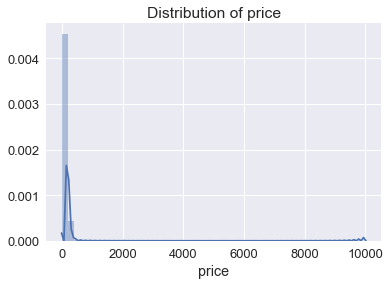

In [27]:
sns.distplot(nyc_listing["price"]).set_title('Distribution of price');

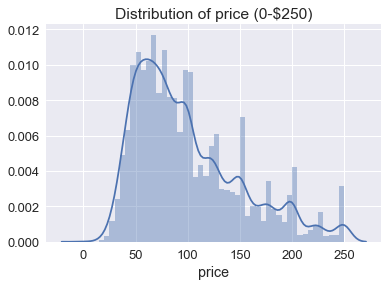

In [28]:
# Narrow down the price range, seems like most price are between $0-$250

sns.distplot(nyc_listing[(nyc_listing["price"] <= 250)]["price"]).set_title('Distribution of price (0-$250)');

In [29]:
# We will remove any one bedroom listing with price over 250
nyc_listing = nyc_listing[nyc_listing['price'] <= 250]

### Borough

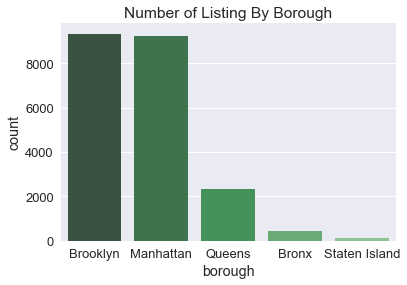

In [30]:
#np.random.seed(sum(map(ord, "categorical")))
sns.countplot(x="borough", data= nyc_listing, palette="Greens_d",
              order = nyc_listing['borough'].value_counts().index).set_title('Number of Listing By Borough');

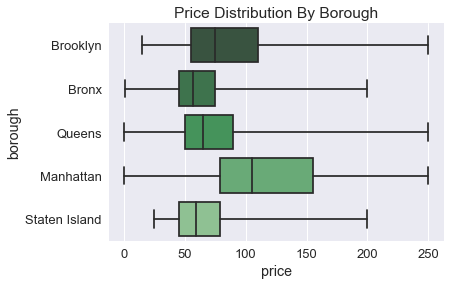

In [31]:
sns.boxplot(x="price", y="borough", data=nyc_listing, whis=np.inf,palette="Greens_d").set_title('Price Distribution By Borough')

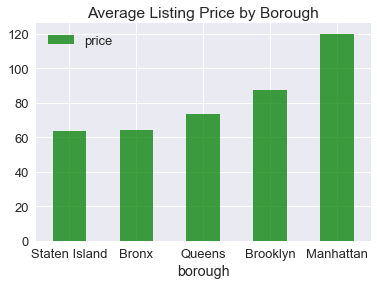

In [32]:
borough_avg = nyc_listing.groupby(['borough'])['price'].mean().reset_index('borough').sort_values('price')
borough_avg.plot(x='borough',y='price',kind='bar',alpha=0.75, rot=0,color='green').set_title('Average Listing Price by Borough')

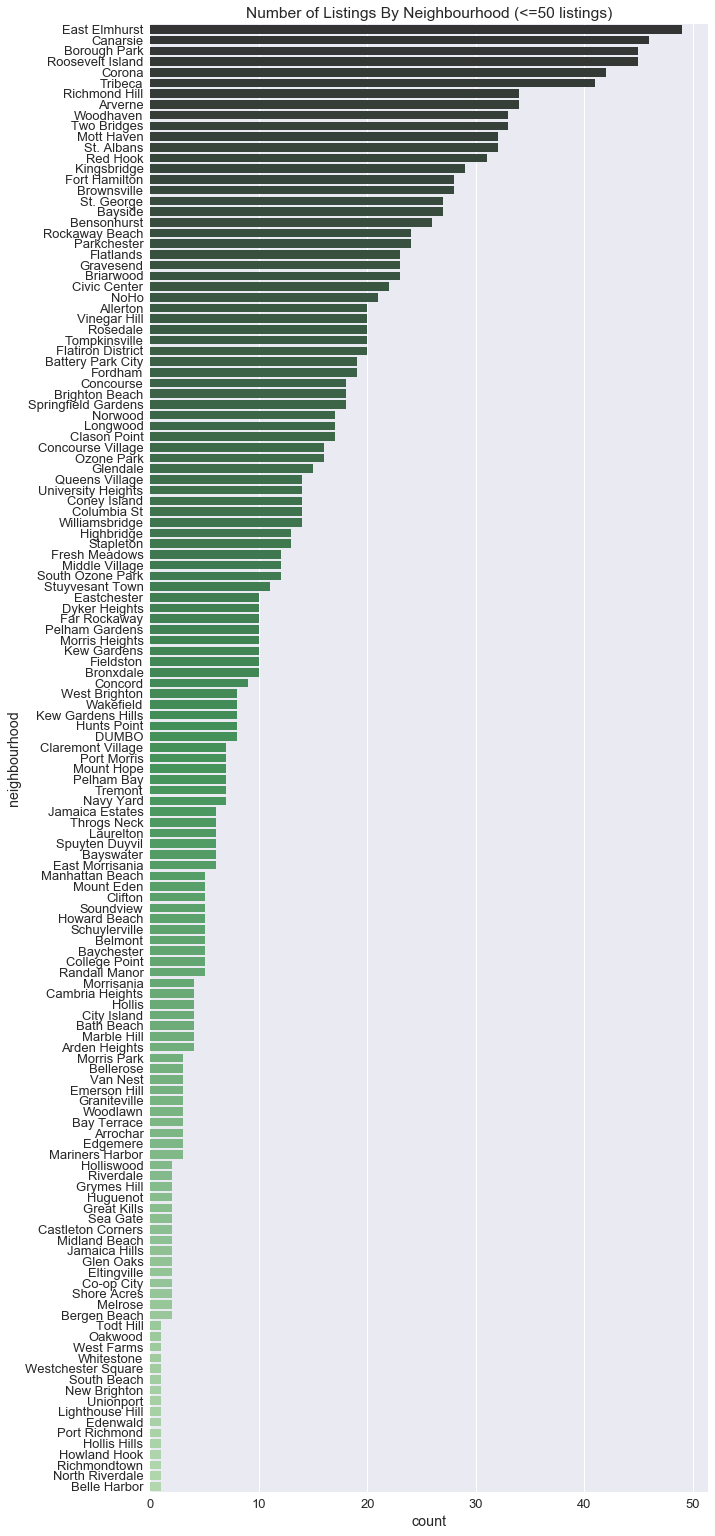

In [33]:
# Consider to drop listings in neighbourhood with or less than 50 listings. Sample size is too small.
fig, ax = plt.subplots(figsize=(10,27))
sns.countplot(y="neighbourhood", data= nyc_listing.groupby("neighbourhood").filter(lambda x: len(x) <= 50), orient='h', palette="Greens_d",
              order = nyc_listing.groupby("neighbourhood").filter(lambda x: len(x)<=50)['neighbourhood'].value_counts().index).set_title('Number of Listings By Neighbourhood (<=50 listings)');

In [34]:
# Drop lines with neighbourhood with or under 50 listings
neighbourhood_under20 = nyc_listing.groupby("neighbourhood").filter(lambda x: len(x)<=50)['neighbourhood'].unique().tolist()
nyc_listing = nyc_listing[nyc_listing["neighbourhood"].isin(neighbourhood_under20) == False]

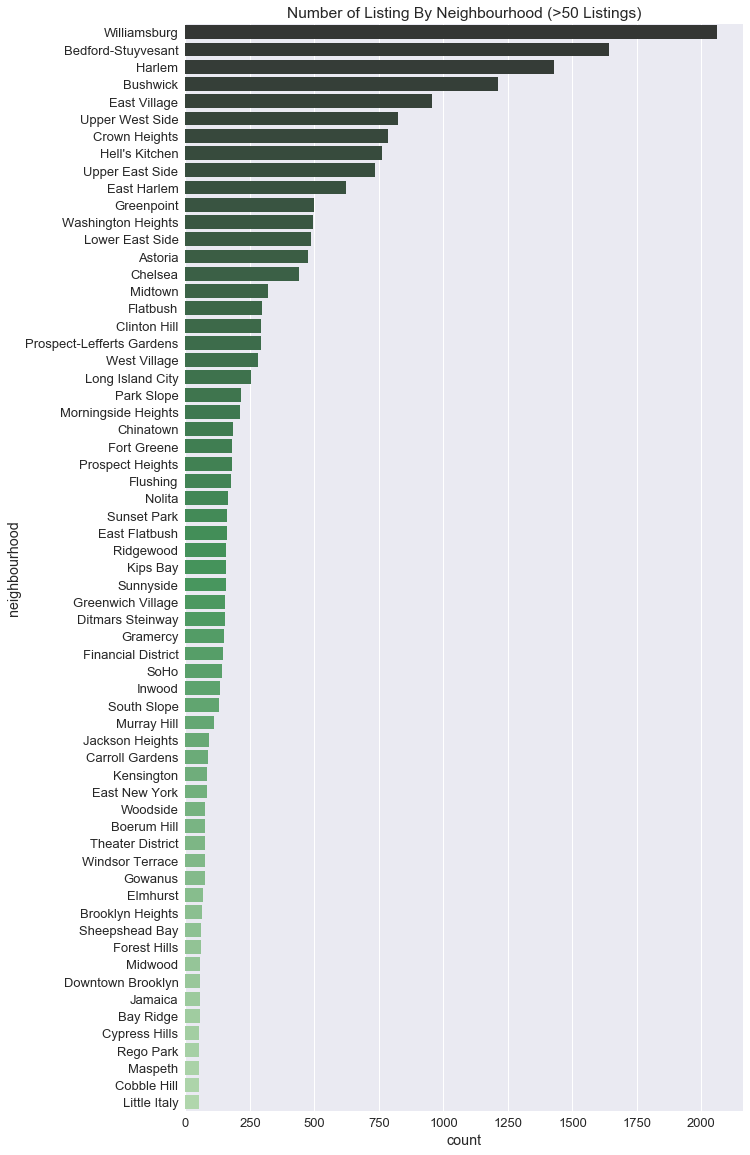

In [35]:
# Neighbourhood with more than 50 listings
fig, ax = plt.subplots(figsize=(10,20))

sns.countplot(y="neighbourhood", data= nyc_listing.groupby("neighbourhood").filter(lambda x: len(x) > 50), orient='h', palette="Greens_d",
              order = nyc_listing.groupby("neighbourhood").filter(lambda x: len(x)>50)['neighbourhood'].value_counts().index).set_title('Number of Listing By Neighbourhood (>50 Listings)');

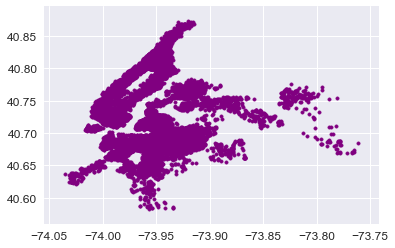

In [56]:
#Scatter Plot MAP
plt.scatter(nyc_listing['longitude'], nyc_listing['latitude'], marker='.', color="purple")

### Accommodates, Bathrooms, Beds

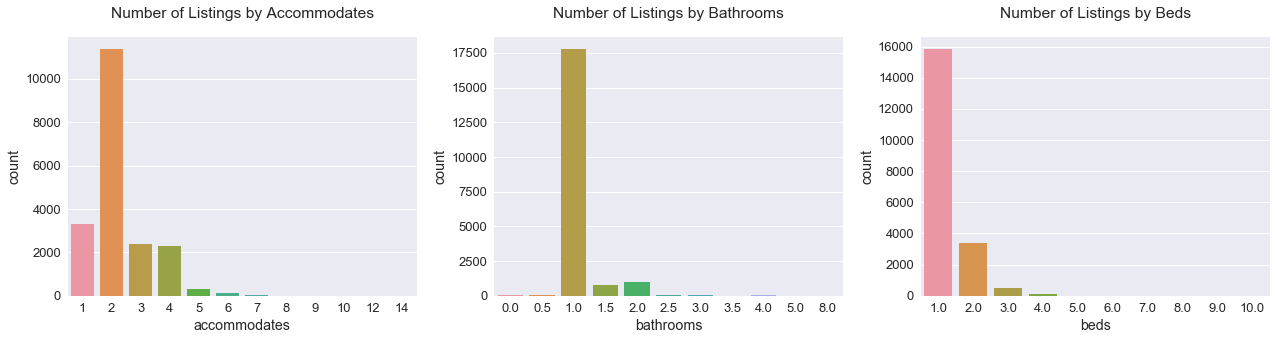

In [36]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18,5))

# The amount of space above titles
y_title_margin = 1.05

sns.countplot(nyc_listing['accommodates'], ax=ax[0]).set_title("Number of Listings by Accommodates",y = y_title_margin)
sns.countplot(nyc_listing['bathrooms'], ax=ax[1]).set_title("Number of Listings by Bathrooms",y = y_title_margin)
sns.countplot(nyc_listing['beds'], ax=ax[2]).set_title("Number of Listings by Beds",y = y_title_margin)

### plt.suptitle("Review", y = 1.09, fontsize=20)
fig.tight_layout()

In [ ]:
# Funny to see for one bedroom listing, some of them can accomodate more than 4 people
# Let's check out these "highly compact" listing
nyc_listing[nyc_listing['accommodates']>8]

In [38]:
# Remove listings with accommodates greater than 4
nyc_listing = nyc_listing[nyc_listing['accommodates']<=4]

In [40]:
# Remove listings with bathroom greater than 2 or less than 1
nyc_listing = nyc_listing[(nyc_listing['bathrooms']<=2) & (nyc_listing['bathrooms']>=1)]

In [42]:
# Remove listings with beds greater than 3
nyc_listing = nyc_listing[nyc_listing['beds']<=3]

### Host Identify Verified, Bed Type, Room Type, and Cancellation Policy

In [43]:
## sns.set_context("paper", rc={"font.size":10,"axes.titlesize":10,"axes.labelsize":7})

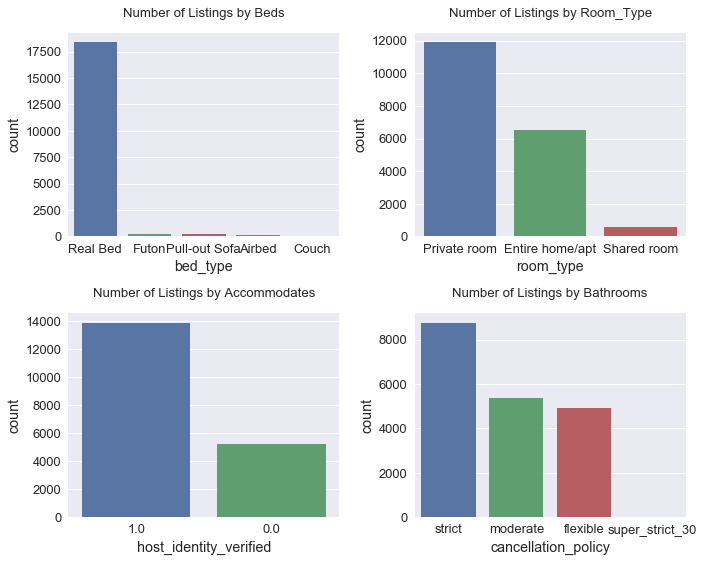

In [44]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,8))
sns.set(font_scale=1.1)
sns.countplot(nyc_listing['host_identity_verified'],ax=ax[1,0],order = nyc_listing['host_identity_verified'].value_counts().index).set_title("Number of Listings by Accommodates",y = y_title_margin)
sns.countplot(nyc_listing['cancellation_policy'],ax=ax[1,1],order = nyc_listing['cancellation_policy'].value_counts().index).set_title("Number of Listings by Bathrooms",y = y_title_margin)
sns.countplot(nyc_listing['bed_type'], ax=ax[0,0],order = nyc_listing['bed_type'].value_counts().index).set_title("Number of Listings by Beds",y = y_title_margin)
sns.countplot(nyc_listing['room_type'], ax=ax[0,1],order = nyc_listing['room_type'].value_counts().index).set_title("Number of Listings by Room_Type",y = y_title_margin)

### plt.suptitle("Review", y = 1.09, fontsize=20)
fig.tight_layout()

In [45]:
# Merge bed types other than Real Bed into "other" cateogy
def categories(x):
    if (x == "Real Bed"):
        return "Real Bed"
    else:
        return "Other"

nyc_listing["bed_type_merge"] = nyc_listing.apply(lambda x: categories(x["bed_type"]), axis=1)

nyc_listing[["bed_type","bed_type_merge"]].head()

,bed_type,bed_type_merge
0,Real Bed,Real Bed
1,Real Bed,Real Bed
5,Real Bed,Real Bed
10,Real Bed,Real Bed
11,Real Bed,Real Bed


### Review Related Variables

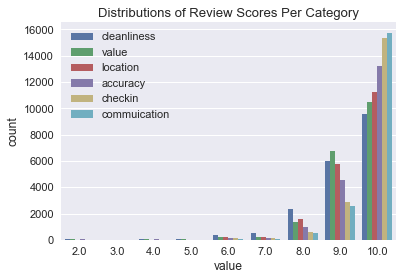

In [46]:
df = nyc_listing[['review_scores_value','review_scores_location','review_scores_communication','review_scores_checkin'
                 ,'review_scores_cleanliness','review_scores_accuracy']]

df.columns = ['value', 'location', 'commuication','checkin','cleanliness','accuracy']

sns.countplot(x="value", hue="variable", 
              hue_order=['cleanliness','value','location','accuracy','checkin','commuication'],
              data=pd.melt(df)).set_title('Distributions of Review Scores Per Category')

plt.legend(loc='upper left')

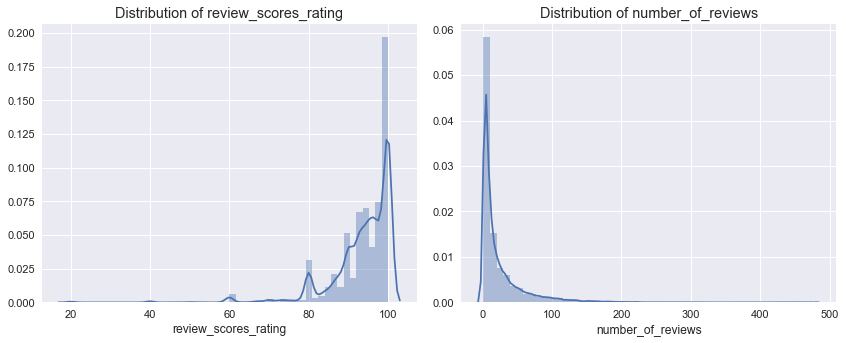

In [47]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
sns.set(font_scale=1.2)
sns.distplot(nyc_listing["review_scores_rating"],ax=ax[0]).set_title('Distribution of review_scores_rating');
sns.distplot(nyc_listing["number_of_reviews"],ax=ax[1]).set_title('Distribution of number_of_reviews');


### plt.suptitle("Review", y = 1.09, fontsize=20)
fig.tight_layout()

In [ ]:
# What kind of listings receive more than 350 reviews over all?? Check them out!
nyc_listing[nyc_listing['number_of_reviews']>350]

In [49]:
# Remove listings with number of reviews greater than 100
nyc_listing = nyc_listing[nyc_listing['number_of_reviews']<=100]

## Create Dummy Variables

In [50]:
nyc_listing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18228 entries, 0 to 41152
Data columns (total 29 columns):
listing_url                    18228 non-null object
name                           18228 non-null object
summary                        18228 non-null object
description                    18228 non-null object
host_identity_verified         18228 non-null float64
neighbourhood                  18228 non-null object
borough                        18228 non-null object
latitude                       18228 non-null float64
longitude                      18228 non-null float64
room_type                      18228 non-null object
accommodates                   18228 non-null int64
bathrooms                      18228 non-null float64
bedrooms                       18228 non-null float64
beds                           18228 non-null float64
bed_type                       18228 non-null object
price                          18228 non-null float64
minimum_nights                 18228 

In [237]:
#create dummy variables for categorical variables, and create new names for our new dummy variables
borough = pd.get_dummies(nyc_listing.borough)
borough.columns = ['borough_' + str(i) for i in borough.columns]

room_type = pd.get_dummies(nyc_listing.room_type )
room_type.columns = ['roomtype_' + str(i) for i in room_type.columns]

bed_type = pd.get_dummies(nyc_listing.bed_type_merge )
bed_type.columns = ['bedtype_' + str(i) for i in bed_type.columns]

cancellation_policy = pd.get_dummies(nyc_listing.cancellation_policy)
cancellation_policy.columns = ['cancellationpolicy_' + str(i) for i in cancellation_policy.columns]

neighbourhood_merge = pd.get_dummies(nyc_listing.neighbourhood)
neighbourhood_merge.columns = ['neighbourhoodmerge_' + str(i) for i in neighbourhood_merge.columns]

In [238]:
#join those new variables back into the larger dataset
nycmodel_data = nyc_listing.join(borough) 
nycmodel_data = nycmodel_data.join(room_type)
nycmodel_data = nycmodel_data.join(bed_type)
nycmodel_data = nycmodel_data.join(cancellation_policy)
nycmodel_data = nycmodel_data.join(neighbourhood_merge)

In [251]:
#Select columns to keep. Set a reference category for each dummy variable and not include them in the model features
# borough: borough_Manhattan
# room_type: roomtype_Private room
# bed_type: bedtype_Real Bed
# cancellation_policy: cancellationpolicy_strict
# neighbourhoodmerge_Williamsburg

#regression coefficients will give you the difference in means 
# (and/or slopes if you’ve included an interaction term) between each other category and the reference category.

columns_to_keep = [
 'host_identity_verified',
 'accommodates',
 'bathrooms',
 #'bedrooms',
 'beds',
 'price',
 'minimum_nights',
 #'maximum_nights',
 'number_of_reviews',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 #'reviews_per_month',
# 'borough_Bronx',
 'borough_Brooklyn',
 'borough_Queens',
 #'borough_Staten Island',
 'roomtype_Entire home/apt',
 'roomtype_Shared room',
 'bedtype_Other',
 'cancellationpolicy_flexible',
 'cancellationpolicy_moderate',
 'cancellationpolicy_super_strict_30',
'neighbourhoodmerge_Astoria',
 'neighbourhoodmerge_Bay Ridge',
 'neighbourhoodmerge_Bedford-Stuyvesant',
 'neighbourhoodmerge_Boerum Hill',
 'neighbourhoodmerge_Brooklyn Heights',
 'neighbourhoodmerge_Bushwick',
 'neighbourhoodmerge_Carroll Gardens',
 'neighbourhoodmerge_Chelsea',
 'neighbourhoodmerge_Chinatown',
 'neighbourhoodmerge_Clinton Hill',
 'neighbourhoodmerge_Cobble Hill',
 'neighbourhoodmerge_Crown Heights',
 'neighbourhoodmerge_Cypress Hills',
 'neighbourhoodmerge_Ditmars Steinway',
 'neighbourhoodmerge_Downtown Brooklyn',
 'neighbourhoodmerge_East Flatbush',
 'neighbourhoodmerge_East Harlem',
 'neighbourhoodmerge_East New York',
 'neighbourhoodmerge_East Village',
 'neighbourhoodmerge_Elmhurst',
 'neighbourhoodmerge_Financial District',
 'neighbourhoodmerge_Flatbush',
 'neighbourhoodmerge_Flushing',
 'neighbourhoodmerge_Forest Hills',
 'neighbourhoodmerge_Fort Greene',
 'neighbourhoodmerge_Gowanus',
 'neighbourhoodmerge_Gramercy',
 'neighbourhoodmerge_Greenpoint',
 'neighbourhoodmerge_Greenwich Village',
 'neighbourhoodmerge_Harlem',
 "neighbourhoodmerge_Hell's Kitchen",
 'neighbourhoodmerge_Inwood',
 'neighbourhoodmerge_Jackson Heights',
 'neighbourhoodmerge_Jamaica',
 'neighbourhoodmerge_Kensington',
 'neighbourhoodmerge_Kips Bay',
 'neighbourhoodmerge_Little Italy',
 'neighbourhoodmerge_Long Island City',
 'neighbourhoodmerge_Lower East Side',
 'neighbourhoodmerge_Maspeth',
 'neighbourhoodmerge_Midtown',
 'neighbourhoodmerge_Midwood',
 'neighbourhoodmerge_Morningside Heights',
 'neighbourhoodmerge_Murray Hill',
 'neighbourhoodmerge_Nolita',
 'neighbourhoodmerge_Park Slope',
 'neighbourhoodmerge_Prospect Heights',
 'neighbourhoodmerge_Prospect-Lefferts Gardens',
 'neighbourhoodmerge_Rego Park',
 'neighbourhoodmerge_Ridgewood',
 'neighbourhoodmerge_Sheepshead Bay',
 'neighbourhoodmerge_SoHo',
 'neighbourhoodmerge_South Slope',
 'neighbourhoodmerge_Sunnyside',
 'neighbourhoodmerge_Sunset Park',
 'neighbourhoodmerge_Theater District',
 'neighbourhoodmerge_Upper East Side',
 'neighbourhoodmerge_Upper West Side',
 'neighbourhoodmerge_Washington Heights',
 'neighbourhoodmerge_West Village',
 'neighbourhoodmerge_Williamsburg',
 'neighbourhoodmerge_Windsor Terrace',
 'neighbourhoodmerge_Woodside',]

## Check Collinearity

In [ ]:
#checking for collinearity
correlations = nycmodel_data[columns_to_keep].corr()
correlations

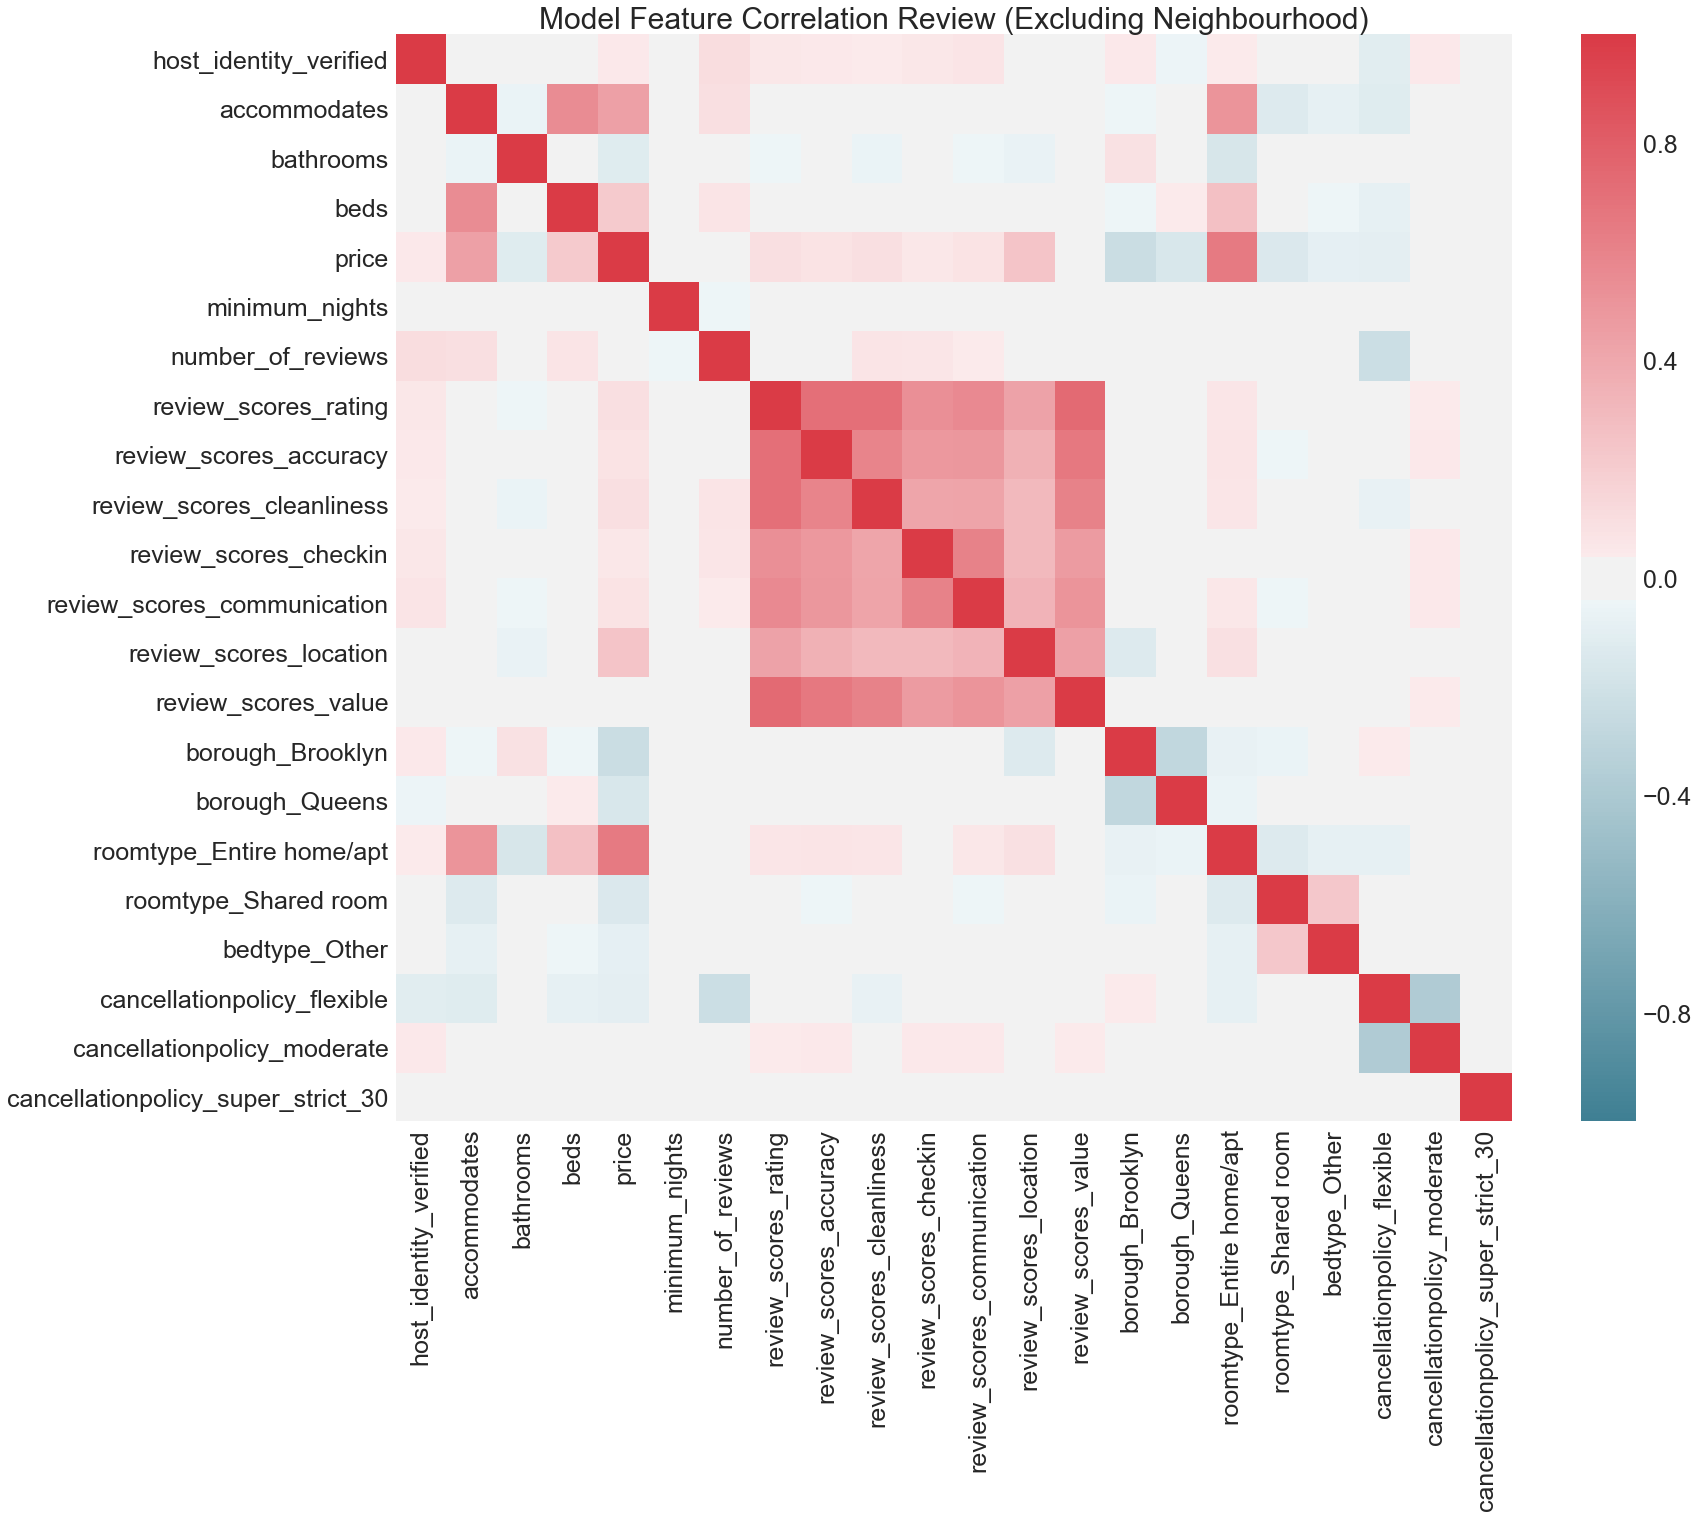

In [253]:
noneighbour_col = [
 'host_identity_verified',
 'accommodates',
 'bathrooms',
 'beds',
 'price',
 'minimum_nights',
 'number_of_reviews',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
# 'borough_Bronx',
 'borough_Brooklyn',
 'borough_Queens',
# 'borough_Staten Island',
 'roomtype_Entire home/apt',
 'roomtype_Shared room',
 'bedtype_Other',
 'cancellationpolicy_flexible',
 'cancellationpolicy_moderate',
 'cancellationpolicy_super_strict_30',]


correlations_noneighbour = nycmodel_data[noneighbour_col].corr()

cmap = sns.diverging_palette(220, 10, as_cmap=True)

plt.figure(figsize=(25, 20))
sns.set(font_scale=2.5)

ax = plt.axes()
ax.set_title('Model Feature Correlation Review (Excluding Neighbourhood)')

sns.heatmap(correlations_noneighbour, cmap=cmap, ax=ax)

## Fit OLS Model Using StatsModel

In [254]:
col_X = columns_to_keep
col_X.remove('price')

In [255]:
y = nycmodel_data['price']
X = nycmodel_data[col_X]

In [256]:
import statsmodels.formula.api as smf

#X = sm.add_constant(X)
lm_stats = sm.OLS(y, X).fit()
lm_stats.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.638
Model:                            OLS   Adj. R-squared:                  0.637
Method:                 Least Squares   F-statistic:                     395.2
Date:                Thu, 02 Nov 2017   Prob (F-statistic):               0.00
Time:                        01:04:56   Log-Likelihood:                -88265.
No. Observations:               18228   AIC:                         1.767e+05
Df Residuals:                   18146   BIC:                         1.773e+05
Df Model:                          81                                         
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
host_identity_verified                           2.2281      0.519      4.289      0.000       1.210       3.246
accommodates                                    10.1613      0.365     27.806      0.000       9.445      10.878
bathrooms                                        1.6240      0.993      1.635      0.102      -0.323       3.571
beds                                            -0.3215      0.637     -0.505      0.614      -1.571       0.928
minimum_nights                                  -0.0913      0.017     -5.376      0.000      -0.125      -0.058
number_of_reviews                               -0.0206      0.011     -1.797      0.072      -0.043       0.002
review_scores_rating                             0.3222      0.052      6.209      0.000       0.220       0.424
review_scores_accuracy                           0.5715      0.429      1.333      0.182      -0.269       1.411
review_scores_cleanliness                        3.4471      0.299     11.511      0.000       2.860       4.034
review_scores_checkin                            0.6438      0.442      1.455      0.146      -0.223       1.511
review_scores_communication                     -0.2071      0.489     -0.423      0.672      -1.166       0.752
review_scores_location                           2.7592      0.358      7.704      0.000       2.057       3.461
review_scores_value                             -5.6515      0.426    -13.253      0.000      -6.487      -4.816
borough_Brooklyn                                 4.2771      4.314      0.992      0.321      -4.178      12.732
borough_Queens                                  -7.1387      4.193     -1.702      0.089     -15.358       1.081
roomtype_Entire home/apt                        49.6616      0.588     84.403      0.000      48.508      50.815
roomtype_Shared room                           -18.5188      1.385    -13.368      0.000     -21.234     -15.803
bedtype_Other                                   -2.6287      1.304     -2.016      0.044      -5.184      -0.073
cancellationpolicy_flexible                     -0.6244      0.585     -1.068      0.286      -1.771       0.522
cancellationpolicy_moderate                     -0.2518      0.553     -0.455      0.649      -1.337       0.833
cancellationpolicy_super_strict_30             -15.9301     30.930     -0.515      0.607     -76.557      44.696
neighbourhoodmerge_Astoria                       2.1393      1.671      1.280      0.200      -1.136       5.414
neighbourhoodmerge_Bay Ridge                   -11.8099      4.154     -2.843      0.004     -19.953      -3.667
neighbourhoodmerge_Bedford-Stuyvesant           -8.9959      0.978     -9.199      0.000     -10.913      -7.079
neighbourhoodmerge_Boerum Hill  

## Training and Testing Data

** Use model_selection.train_test_split from sklearn to split the data into training and testing sets. Set test_size=0.3 and random_state=101**

In [257]:
from sklearn.model_selection import train_test_split

In [258]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

## Training the Model

In [259]:
from sklearn.linear_model import LinearRegression

#Create an instance of a LinearRegression() model named lm
lm = LinearRegression()

# Train/fit lm on the training data
lm.fit(X_train,y_train)

# The coefficients
print('Coefficients: \n', lm.coef_)

('Coefficients: \n', array([  1.84321225e+00,   9.79739117e+00,   2.19765958e+00,
        -3.13537914e-01,  -1.91297013e-01,  -2.67519965e-02,
         3.20731697e-01,  -4.05664408e-02,   3.84965665e+00,
         6.68786019e-01,   1.46106899e-01,   2.49373972e+00,
        -5.90713622e+00,  -2.13153514e+12,  -3.74122978e+11,
         4.96037932e+01,  -1.77973798e+01,  -3.91866796e+00,
        -7.65146442e-01,   3.10841406e-02,   8.71112265e+09,
        -4.36639424e+11,   1.32077274e+12,   1.32077274e+12,
         1.32077274e+12,   1.32077274e+12,   1.32077274e+12,
         1.32077274e+12,  -8.10762402e+11,  -8.10762402e+11,
         1.32077274e+12,   1.32077274e+12,   1.32077274e+12,
         1.32077274e+12,  -4.36639424e+11,   1.32077274e+12,
         1.32077274e+12,  -8.10762402e+11,   1.32077274e+12,
        -8.10762402e+11,  -4.36639424e+11,  -8.10762402e+11,
         1.32077274e+12,  -4.36639424e+11,  -4.36639424e+11,
         1.32077274e+12,   1.32077274e+12,  -8.10762402e+11,
   

## Predicting Test Data
Now that we have fit our model, let's evaluate its performance by predicting off the test values!

In [260]:
predictions = lm.predict( X_test)

In [ ]:
# Create a scatterplot of the real test values versus the predicted values
plt.scatter(y_test,predictions)
fig.suptitle('Real Test Values vs. Predicted Values', fontsize=20)
plt.xlabel('Y Test', fontsize=18)
plt.ylabel('Predicted Y', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

## Evaluating the Model
Let's evaluate our model performance by calculating the residual sum of squares and the explained variance score (R^2).

In [154]:
## calculate these metrics by hand!
from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
print('R2', metrics.r2_score(y_test, predictions))
print('Adjusted R2', 1 - (1-metrics.r2_score(y_test, predictions))*(len(y)-1)/(len(y)-X.shape[1]-1))

('MAE:', 22.64790031679215)
('MSE:', 945.6488086738392)
('RMSE:', 30.75140336104743)
('R2', 0.63746711003500856)
('Adjusted R2', 0.63582208179618727)


#### Adjusted R squared: Penalizes model complexity (to control for overfitting), but it generally under-penalizes complexity

## Residuals

Explore the residuals to make sure everything was okay with our data. 

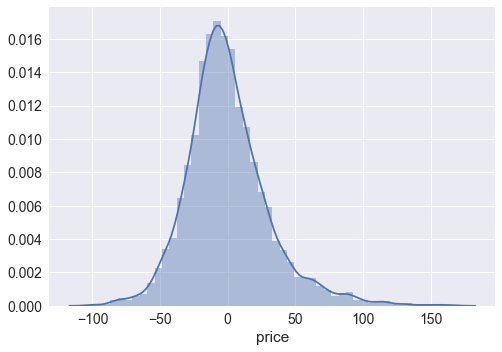

In [155]:
# Plot a histogram of the residuals and make sure it looks normally distributed. Use either seaborn distplot, or just plt.hist().
sns.set(font_scale=1.4)
sns.distplot((y_test-predictions),bins=50);

## Cross Validation

In [156]:
from sklearn import cross_validation

In [157]:
y = nycmodel_data['price']
#X = nycmodel_data[col_X]

#adding neighbourhood variables in
X = nycmodel_data[col_X]# Create a cross valiation with 5 folds

In [158]:
kf = cross_validation.KFold(len(X), n_folds=5, shuffle=True)

mse_values = []
scores = []
n= 0
print "~~~~ CROSS VALIDATION each fold ~~~~"
for train_index, test_index in kf:
    lm = LinearRegression().fit(X.iloc[train_index], y.iloc[train_index])
    mse_values.append(metrics.mean_squared_error(y.iloc[test_index], lm.predict(X.iloc[test_index])))
    scores.append(lm.score(X, y))
    n+=1
    print 'Model', n
    print 'MSE:', mse_values[n-1]
    print 'R2:', scores[n-1]


print "~~~~ SUMMARY OF CROSS VALIDATION ~~~~"
print 'Mean of MSE for all folds:', np.mean(mse_values)
print 'Mean of R2 for all folds:', np.mean(scores)

~~~~ CROSS VALIDATION each fold ~~~~
Model 1
MSE: 954.26540738
R2: 0.637787101143
Model 2
MSE: 926.500820621
R2: 0.638701413754
Model 3
MSE: 974.180810532
R2: 0.638656412298
Model 4
MSE: 994.677353289
R2: 0.638710453279
Model 5
MSE: 8.36340100041e+15
R2: -633941191817.0
~~~~ SUMMARY OF CROSS VALIDATION ~~~~
Mean of MSE for all folds: 1.67268020008e+15
Mean of R2 for all folds: -126788238363.0


In [159]:
lm = LinearRegression().fit(X, y)
print "~~~~ Single Model ~~~~"
print 'MSE of single model:', metrics.mean_squared_error(y, lm.predict(X))
print 'R2: ', lm.score(X, y)

~~~~ Single Model ~~~~
MSE of single model: 952.311783854
R2:  0.639037635717


#### Ways to improve model regularization

In [160]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

lm = LinearRegression().fit(X, y)
print "~~~ OLS ~~~"
print 'OLS MSE: ', metrics.mean_squared_error(y, lm.predict(X))
print 'OLS R2:', lm.score(X, y)

lm = Lasso().fit(X, y)
print "~~~ Lasso ~~~"
print 'Lasso MSE: ', metrics.mean_squared_error(y, lm.predict(X))
print 'Lasso R2:', lm.score(X, y)

lm = Ridge().fit(X, y)
print "~~~ Ridge ~~~"
print 'Ridge MSE: ', metrics.mean_squared_error(y, lm.predict(X))
print 'Ridge R2:', lm.score(X, y)

~~~ OLS ~~~
OLS MSE:  952.311783854
OLS R2: 0.639037635717
~~~ Lasso ~~~
Lasso MSE:  1194.61277925
Lasso R2: 0.547196348388
~~~ Ridge ~~~
Ridge MSE:  952.32462734
Ridge R2: 0.639032767547


## Conclusion

In [ ]:
coeffecients = pd.DataFrame(lm.coef_,X.columns)
coeffecients.columns = ['Coeffecient']
coeffecients.sort_values(coeffecients.columns[0], ascending=False, inplace=True)
coeffecients

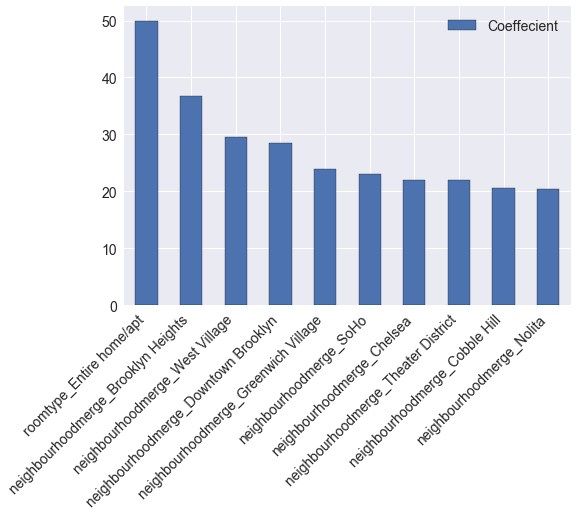

In [163]:
coeffecients[0:10].plot(kind='bar', edgecolor="#000000")
plt.xticks(rotation=45, ha='right');

Interpreting the coefficients:

- Holding all other features fixed, if listing room type is Entire home/apt, than the price is \$50 higher than private bedroom room type.
- Holding all other features fixed, if listing neighbourhood is Brooklyn Heights, than the price is $36 higher than listing in williamsburg.

## Next Steps
-  Use Random Forest Regresor to fit model and compare result with OLS result
-  Explore usage of text data